# Setup

In [6]:
import gymnasium as gym
env = gym.make('MountainCar-v0')
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from matplotlib import pyplot as plt

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from dqn import QNetwork, DQNAgent, ReplayBuffer

Utiliser sans le target

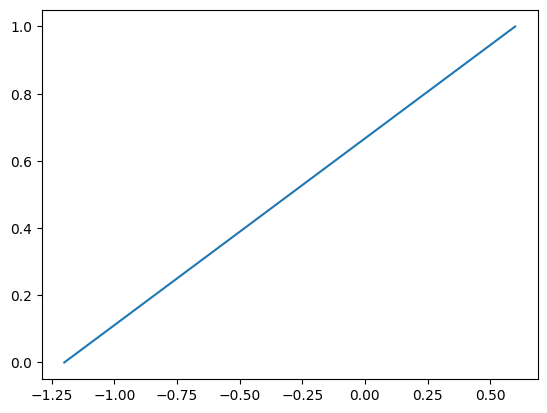

In [8]:
x = np.linspace(-1.2, 0.6, 100)
plt.plot(x, (1.8-(0.6-x))/1.8)

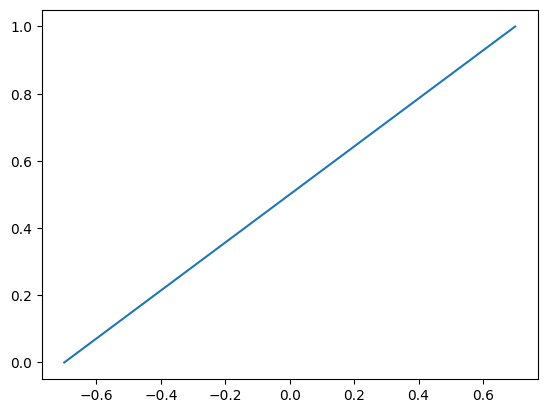

In [9]:
x = np.linspace(-0.7, 0.7, 100)
plt.plot(x, (1.4-(0.7-x))/1.4)

In [11]:
intermediate_reward = 1

In [12]:
pos = np.linspace(-1.2, 0.6, 100)
vel = np.linspace(-0.07, 0.07, 100)

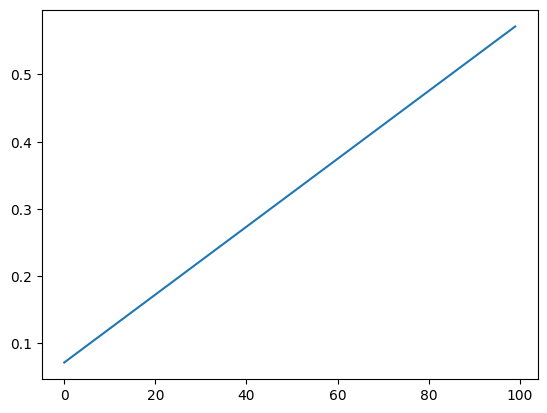

In [13]:
plt.plot(0.5*intermediate_reward*(1.8-(0.6-pos))/1.8+0.5*intermediate_reward*(np.abs(0.1))/0.7)

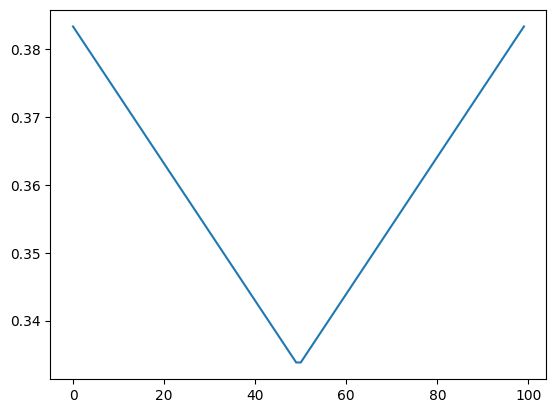

In [14]:
plt.plot(0.5*intermediate_reward*(1.8-(0.6-0))/1.8+0.5*intermediate_reward*(np.abs(vel))/0.7)

In [6]:
# hyperparameters
learning_rate = 1e-3
n_episodes = 3_000
start_epsilon = 0.9
final_epsilon = 0.05
epsilon_decay = 0.99
# reduce the exploration over time
batch_size = 64
discount_factor = 0.99
replay_size = 10_000
logging_interval = 50
hidden_size=64
dropout_rate=0.1
weight_decay=1e-4
target_network = False
target_network_update = int(1e4)
alpha = 0
np.random.seed(42)
auxiliary = True
intermediate_reward = 1
final_reward = 100
amsgrad = False

In [7]:
agent = DQNAgent(
    learning_rate=learning_rate,
    state_size=2,
    action_size=3,
    discount_factor=discount_factor,
    final_epsilon=final_epsilon,
    hidden_size=hidden_size,
    epsilon_decay=epsilon_decay,
    initial_epsilon=start_epsilon,
    replay_size=replay_size,
    dropout_rate=dropout_rate,
    target_network=target_network,
    weight_decay=weight_decay,
    target_network_update=target_network_update,
    alpha=alpha,
    amsgrad=amsgrad
)

In [8]:
run = wandb.init(project='ANN', config={"learning_rate": learning_rate, "n_episodes": n_episodes, "start_epsilon": start_epsilon, "final_epsilon": final_epsilon, "epsilon_decay": epsilon_decay, "batch_size": batch_size, "discount_factor": discount_factor, "replay_size": replay_size, "hidden_size": hidden_size, "dropout_rate": dropout_rate, "weight_decay":weight_decay, "target_network":target_network, "alpha":alpha,"target_network_update":target_network_update, "auxiliary":auxiliary, "final_reward":final_reward, "intermediate_reward":intermediate_reward, "amsgrad":amsgrad}, name='DQN')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nreateguir (reategui). Use `wandb login --relogin` to force relogin


In [9]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
with tqdm(total=n_episodes, desc=f"Episode 0/{n_episodes}") as pbar:
    losses = []
    rewards = []
    target_count = 0
    finished = []
    episode_steps = []
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False
        # play one episode
        t = 0
        episode_reward = 0
        episode_loss = 0
        
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            # update if the environment is done and the current obs
            done = terminated or truncated
            if terminated:
                next_obs = (None, None)
                reward+=final_reward
            reward+=intermediate_reward*(1.8-(0.6-next_obs[0]))/1.8

            loss, target_count = agent.update(obs, action, reward, next_obs, batch_size=batch_size, target_count=target_count)
            if loss is not None:
                episode_reward += reward
                episode_loss+=loss
            obs = next_obs
            t+=1
        finished.append(terminated)
        episode_steps.append(t)
        rewards.append(episode_reward)
        losses.append(episode_loss)
        agent.decay_epsilon()
        pbar.set_description(f"Episode {episode + 1}/{n_episodes}")
        pbar.set_postfix(train_loss=loss, epsilon=agent.epsilon, target_count=target_count)
        pbar.update(1)
        pbar.refresh() 
        if episode % logging_interval == 0 and episode>100:
            wandb.log({"train_loss": np.mean(losses), "epsilon": agent.epsilon, "episode_steps": np.mean(episode_steps), "finished": np.sum(finished), "mean_reward": np.mean(rewards)})
            losses = []
            rewards = []
            finished = []
            episode_steps = []


Episode 161/3000:   5%|▌         | 161/3000 [01:11<31:28,  1.50it/s, epsilon=0.295, target_count=22201, train_loss=1.36] 

In [ ]:
wandb.finish()